##Challenge 1
- Open up a new ipython notebook
- Download a few mta turnstile data files
- Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like


        {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
               ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],          
                 ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],  
                ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
              ...   
         ] 
        }


In [165]:
url_template = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt'
for date in ['150124', '150117', '150110', '150103']:
    url = url_template % date
    !wget {url}

--2015-01-27 16:15:19--  http://web.mta.info/developers/data/nyct/turnstile/turnstile_150124.txt
Resolving web.mta.info... 173.223.204.97, 173.223.204.56
Connecting to web.mta.info|173.223.204.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'turnstile_150124.txt.1'

turnstile_150124.tx     [                 <=>  ]  24.10M  7.48MB/s   in 3.3s   

2015-01-27 16:15:22 (7.29 MB/s) - 'turnstile_150124.txt.1' saved [25266756]

--2015-01-27 16:15:23--  http://web.mta.info/developers/data/nyct/turnstile/turnstile_150117.txt
Resolving web.mta.info... 173.223.204.56, 173.223.204.97
Connecting to web.mta.info|173.223.204.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'turnstile_150117.txt.1'

turnstile_150117.tx     [               <=>    ]  25.14M  1.08MB/s   in 22s    

2015-01-27 16:15:46 (1.12 MB/s) - 'turnstile_150117.txt.1' saved [26361916]

--2015-01-27 16:15:46-

In [214]:
import csv, glob
from collections import defaultdict

def read_csv(csv_file_name):

    turnstile_to_count_reading = defaultdict(list)
    with open(csv_file_name, 'r') as csv_file:
        mta_reader = csv.reader(csv_file)
        for i, row in enumerate(mta_reader):
            # skip the first row, it's just header strings
            if i == 0:
                continue
            # read the rest
            turnstile_info = tuple(row[:4])
            count_reading = row[4:]
            turnstile_to_count_reading[turnstile_info].append(count_reading)
    return turnstile_to_count_reading


#A) List comprehension
#weekly_data_dicts = [read_csv(csvfile) for csvfile in glob.glob("turnstile_*.txt")]

#B) Alternatively, map
data_files = glob.glob("turnstile_*.txt")
weekly_data_dicts = map(read_csv, data_files)

#C) Alternatively, separating the steps on multiple lines
#weekly_data_dicts = []
#for data_file in glob.glob("turnstile_*.txt"):
#    print 'Processing %s' % data_file
#    weekly_data_dicts.append(read_csv(data_file))
    
#(Choose the approach you find more readable)

In [215]:
from pprint import pprint
# just get 2 keys from the first dict to now overwhelm the output
sample_dict = dict(weekly_data_dicts[0].items()[:2])
pprint(sample_dict)

{('A030', 'R083', '01-06-00', '23 ST-5 AVE'): [['NR',
                                                'BMT',
                                                '12/27/2014',
                                                '03:00:00',
                                                'REGULAR',
                                                '0005576939',
                                                '0003135814                                           '],
                                               ['NR',
                                                'BMT',
                                                '12/27/2014',
                                                '07:00:00',
                                                'REGULAR',
                                                '0005576950',
                                                '0003135823                                           '],
                                               ['NR',
                              

##Challenge 2
- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the cumulative count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the [dateutil][1] module to convert it into a datetime object. For an example check [this StackOverflow question][2].

Your new dict should look something like
 
    {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
                [datetime.datetime(2013, 3, 2, 3, 0), 3788],
                [datetime.datetime(2013, 3, 2, 7, 0), 2585],
                [datetime.datetime(2013, 3, 2, 12, 0), 10653],
                [datetime.datetime(2013, 3, 2, 17, 0), 11016],
                [datetime.datetime(2013, 3, 2, 23, 0), 10666],
                [datetime.datetime(2013, 3, 3, 3, 0), 10814],
                [datetime.datetime(2013, 3, 3, 7, 0), 10229],
                ...
              ],
     ....
     }



In [223]:
from itertools import groupby
from operator import itemgetter

def count_within_normal_bounds(count):
    if count is None:
        return True
    else:
        return 10000 > count >= 0

def convert_time_series_to_daily(high_res_time_series):
    daily_time_series = []
    # I can define a function WITHIN another function. It will only
    # be defined within the scope of the mother function
    def day_of_timestamp(time_series_entry):
        timestamp, tot_entries = time_series_entry
        # the .date() method of a datetime object returns the day
        #(as another datetime object)
        return timestamp.date()
    # groupby() requires data to be sorted. It is sorted already here,
    # but if it wasn't, we would have to sort it first
    count_on_previous_day = None
    for day, entries_on_this_day in groupby(high_res_time_series,
                                                      key=day_of_timestamp):
        # get the maximum cumulative count among the entries on this day
        cum_entry_count_on_day = max([count for time, count in entries_on_this_day])
        # skip the first entry if we don't know the previous day
        if count_on_previous_day is None:
            daily_entries = None
        else:
            daily_entries = cum_entry_count_on_day - count_on_previous_day
        # Save today's count for tomorrow's calculation
        count_on_previous_day = cum_entry_count_on_day
        # Only append if the cumulative increased. Otherwise there is something wrong in the data
        # skip with a warning
        if count_within_normal_bounds(daily_entries):
            daily_time_series.append( (day, daily_entries) )
        else:
            print ('WARNING. Abnormal entry count found '
                   'on day %s: %s' % (day, daily_entries))
            daily_time_series.append( (day, None) )

    return daily_time_series


def combine_multiple_weeks_into_single_high_res_timeseries(weekly_time_series):
    combined_time_series = defaultdict(list)
    for turnstile_to_weeklong_time_series in weekly_time_series:
        for turnstile, weeklong_time_series in turnstile_to_weeklong_time_series.iteritems():
            combined_time_series[turnstile] += weeklong_time_series
    # It's already sorted due to the nature of the files but if not you would want to sort
    # the dates first before retiurning it
    return combined_time_series


def convert_turnstile_to_high_res_time_series_to_daily(turnstile_to_time_series):
    turnstile_to_daily_time_series = {}
    for i, (turnstile, time_series) in enumerate(turnstile_to_time_series.iteritems()):
        print 'Processing turnstile', turnstile
        turnstile_to_daily_time_series[turnstile] = convert_time_series_to_daily(time_series)
    return turnstile_to_daily_time_series


turnstile_to_full_time_series = combine_multiple_weeks_into_single_high_res_timeseries(weekly_time_series)
turnstile_to_daily_time_series = convert_turnstile_to_high_res_time_series_to_daily(turnstile_to_full_time_series)


Processing turnstile ('A030', 'R083', '01-06-00', '23 ST-5 AVE')
Processing turnstile ('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')
Processing turnstile ('B014', 'R148', '00-00-01', 'PARKSIDE AVE')
Processing turnstile ('A013', 'R081', '01-03-00', '49 ST-7 AVE')
Processing turnstile ('B016', 'R098', '00-00-01', 'CHURCH AVE')
Processing turnstile ('R159', 'R164', '01-06-00', '66 ST-LINCOLN')
Processing turnstile ('N013', 'R035', '02-00-03', '168 ST-BROADWAY')
Processing turnstile ('H016', 'R250', '00-00-02', 'GRAND ST')
Processing turnstile ('A069', 'R044', '01-00-02', 'CHAMBERS ST')
Processing turnstile ('G001', 'R151', '00-00-03', 'STILLWELL AVE')
Processing turnstile ('R619', 'R059', '00-00-01', 'GRAND ARMY PLAZ')
Processing turnstile ('N016A', 'R296', '00-00-02', '163 ST-AMSTERDM')
Processing turnstile ('H027', 'R137', '01-06-01', 'MYRTLE AVE')
Processing turnstile ('R190', 'R038', '00-00-02', '215 ST')
Processing turnstile ('A002', 'R051', '02-00-00', 'LEXINGTON AVE')
Processing tu

In [216]:
from datetime import datetime
from dateutil.parser import parse
from collections import defaultdict


def convert_week_data_to_time_series(week_data_dict):
    turnstile_to_time_series = defaultdict(list)
    for i, (turnstile, row_data) in enumerate(week_data_dict.iteritems()):
        # report every 100 turnstiles
        if i%100 == 0:
            print 'Processing turnstile', turnstile
        for lines, division, datestr, timestr, event, cum_entries, cum_exits in row_data:
            timestamp = parse('%sT%s' % (datestr,timestr))
            turnstile_to_time_series[turnstile].append([timestamp, int(cum_entries)])
    return turnstile_to_time_series


# this takes a while
weekly_time_series = map(convert_week_data_to_time_series, weekly_data_dicts)


Processing turnstile ('A030', 'R083', '01-06-00', '23 ST-5 AVE')
Processing turnstile ('R231A', 'R176', '01-06-01', '33 ST')
Processing turnstile ('R244', 'R050', '00-06-02', '59 ST')
Processing turnstile ('R524', 'R347', '00-05-01', '69 ST-FISK AVE')
Processing turnstile ('N003', 'R185', '00-00-01', 'DYCKMAN-200 ST')
Processing turnstile ('N083', 'R138', '01-02-00', 'W 4 ST-WASH SQ')
Processing turnstile ('N342', 'R019', '01-03-02', 'JAMAICA-179 ST')
Processing turnstile ('N072', 'R012', '05-00-03', '34 ST-PENN STA')
Processing turnstile ('R210', 'R044', '00-03-01', 'BROOKLYN BRIDGE')
Processing turnstile ('C008', 'R099', '00-00-03', 'DEKALB AVE')
Processing turnstile ('N333B', 'R141', '02-00-00', 'FOREST HILLS-71')
Processing turnstile ('C008', 'R099', '00-04-01', 'DEKALB AVE')
Processing turnstile ('N301', 'R113', '00-00-02', '7 AVE-53 ST')
Processing turnstile ('R243', 'R049', '00-00-01', '51 ST')
Processing turnstile ('N063A', 'R011', '00-00-03', '42 ST-PA BUS TE')
Processing turn

In [217]:
# Checking the result
# just get 2 keys from the first dict to now overwhelm the output
sample_turnstile_to_time_series = dict(weekly_time_series[0].items()[:2])
pprint(sample_turnstile_to_time_series)

{('A030', 'R083', '01-06-00', '23 ST-5 AVE'): [[datetime.datetime(2014, 12, 27, 3, 0),
                                                5576939],
                                               [datetime.datetime(2014, 12, 27, 7, 0),
                                                5576950],
                                               [datetime.datetime(2014, 12, 27, 11, 0),
                                                5577003],
                                               [datetime.datetime(2014, 12, 27, 15, 0),
                                                5577162],
                                               [datetime.datetime(2014, 12, 27, 19, 0),
                                                5577448],
                                               [datetime.datetime(2014, 12, 27, 23, 0),
                                                5577680],
                                               [datetime.datetime(2014, 12, 28, 3, 0),
                                       

##Challenge 3
- These counts are cumulative every n hours. We want total daily entries. 

Now make it that we again have the same keys, but now we have a single value for a single day, which is not cumulative counts but the total number of passengers that entered through this turnstile on this day.


In [226]:
# Let's check
pprint( turnstile_to_daily_time_series[('R238', 'R046', '00-00-08', '42 ST-GRD CNTRL')] )

[(datetime.date(2014, 12, 27), None),
 (datetime.date(2014, 12, 28), 2941),
 (datetime.date(2014, 12, 29), 5916),
 (datetime.date(2014, 12, 30), 6099),
 (datetime.date(2014, 12, 31), 5441),
 (datetime.date(2015, 1, 1), 2575),
 (datetime.date(2015, 1, 2), 4809),
 (datetime.date(2015, 1, 3), 3054),
 (datetime.date(2015, 1, 4), 2382),
 (datetime.date(2015, 1, 5), 6462),
 (datetime.date(2015, 1, 6), 6789),
 (datetime.date(2015, 1, 7), 6515),
 (datetime.date(2015, 1, 8), 6385),
 (datetime.date(2015, 1, 9), 6490),
 (datetime.date(2015, 1, 10), 2855),
 (datetime.date(2015, 1, 11), 2177),
 (datetime.date(2015, 1, 12), 8796),
 (datetime.date(2015, 1, 13), 6722),
 (datetime.date(2015, 1, 14), 6212),
 (datetime.date(2015, 1, 15), 7494),
 (datetime.date(2015, 1, 16), 6340),
 (datetime.date(2015, 1, 17), 2653),
 (datetime.date(2015, 1, 18), 1913),
 (datetime.date(2015, 1, 19), 3429),
 (datetime.date(2015, 1, 20), 6484),
 (datetime.date(2015, 1, 21), 6504),
 (datetime.date(2015, 1, 22), 8054),
 (dat

##Challenge 4
- We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:    

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the notebook.
To plot the time series, import matplotlib with 

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)


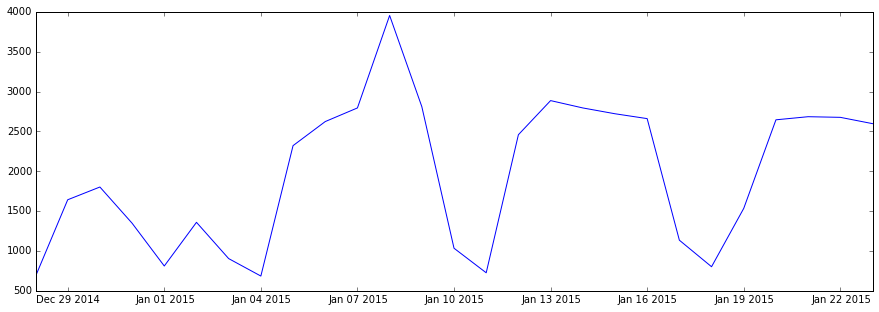

In [227]:
%matplotlib inline
import matplotlib.pyplot as plt

time_series = turnstile_to_daily_time_series[('A030', 'R083', '01-06-00', '23 ST-5 AVE')]
days, counts = zip(*time_series)
plt.figure(figsize=(15,5))
plt.plot(days,counts)

##Challenge 5
- So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.


In [228]:
from collections import Counter

def booth_of_a_turnstile(turnstile):
    control_area, unit, device_id, station = turnstile
    return (control_area, unit, station)

def booth_of_a_time_series_item(item):
    turnstile, time_series = item
    return booth_of_a_turnstile(turnstile)

def reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series):
    turnstile_time_series_items = sorted(turnstile_to_daily_time_series.items())
    booth_to_time_series = {}
    for booth, item_list_of_booth in groupby(turnstile_time_series_items,
                                             key=booth_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_booth:
            for day, count in time_series:
                if count is not None:
                    daily_counter[day] += count
                
        booth_to_time_series[booth] = sorted(daily_counter.items())

    return booth_to_time_series


booth_to_daily_time_series = reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series)

In [229]:
#Check
pprint(booth_to_daily_time_series[('A030', 'R083', '23 ST-5 AVE')])

[(datetime.date(2014, 12, 28), 5699),
 (datetime.date(2014, 12, 29), 11454),
 (datetime.date(2014, 12, 30), 12366),
 (datetime.date(2014, 12, 31), 9163),
 (datetime.date(2015, 1, 1), 5328),
 (datetime.date(2015, 1, 2), 9948),
 (datetime.date(2015, 1, 3), 6352),
 (datetime.date(2015, 1, 4), 4684),
 (datetime.date(2015, 1, 5), 13969),
 (datetime.date(2015, 1, 6), 14595),
 (datetime.date(2015, 1, 7), 14890),
 (datetime.date(2015, 1, 8), 14755),
 (datetime.date(2015, 1, 9), 12964),
 (datetime.date(2015, 1, 10), 7457),
 (datetime.date(2015, 1, 11), 5837),
 (datetime.date(2015, 1, 12), 13860),
 (datetime.date(2015, 1, 13), 15652),
 (datetime.date(2015, 1, 14), 15148),
 (datetime.date(2015, 1, 15), 15046),
 (datetime.date(2015, 1, 16), 14636),
 (datetime.date(2015, 1, 17), 7466),
 (datetime.date(2015, 1, 18), 4857),
 (datetime.date(2015, 1, 19), 8360),
 (datetime.date(2015, 1, 20), 14696),
 (datetime.date(2015, 1, 21), 14990),
 (datetime.date(2015, 1, 22), 14953),
 (datetime.date(2015, 1, 23)

##Challenge 6
- Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

In [230]:
def station_of_a_booth(booth):
    control_area, unit, station = booth
    return station

def station_of_a_time_series_item(item):
    booth, time_series = item
    return station_of_a_booth(booth)

def reduce_booth_time_series_to_stations(booth_to_daily_time_series):
    booth_time_series_items = sorted(booth_to_daily_time_series.items())
    station_to_time_series = {}
    for station, item_list_of_station in groupby(booth_time_series_items,
                                             key=station_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_station:
            for day, count in time_series:
                daily_counter[day] += count
        station_to_time_series[station] = sorted(daily_counter.items())
    return station_to_time_series


station_to_daily_time_series = reduce_booth_time_series_to_stations(booth_to_daily_time_series)

In [231]:
pprint(station_to_daily_time_series['14 ST-UNION SQ'])

[(datetime.date(2014, 12, 28), 19688),
 (datetime.date(2014, 12, 29), 29393),
 (datetime.date(2014, 12, 30), 31698),
 (datetime.date(2014, 12, 31), 31667),
 (datetime.date(2015, 1, 1), 19605),
 (datetime.date(2015, 1, 2), 28517),
 (datetime.date(2015, 1, 3), 24845),
 (datetime.date(2015, 1, 4), 19788),
 (datetime.date(2015, 1, 5), 32550),
 (datetime.date(2015, 1, 6), 32634),
 (datetime.date(2015, 1, 7), 33368),
 (datetime.date(2015, 1, 8), 31329),
 (datetime.date(2015, 1, 9), 33572),
 (datetime.date(2015, 1, 10), 26064),
 (datetime.date(2015, 1, 11), 23052),
 (datetime.date(2015, 1, 12), 31240),
 (datetime.date(2015, 1, 13), 33766),
 (datetime.date(2015, 1, 14), 34383),
 (datetime.date(2015, 1, 15), 34816),
 (datetime.date(2015, 1, 16), 36092),
 (datetime.date(2015, 1, 17), 26819),
 (datetime.date(2015, 1, 18), 19765),
 (datetime.date(2015, 1, 19), 23975),
 (datetime.date(2015, 1, 20), 33618),
 (datetime.date(2015, 1, 21), 35152),
 (datetime.date(2015, 1, 22), 35067),
 (datetime.date(2

##Challenge 7
- Plot the time series for a station

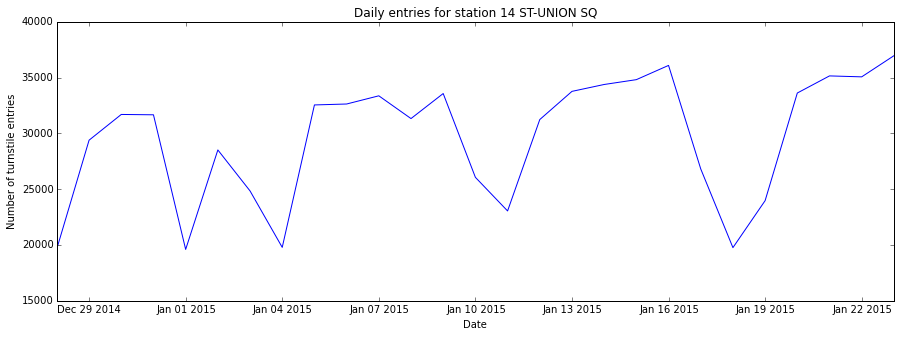

In [232]:
def plot_station_time_series(station_name, station_to_daily_time_series):
    time_series = station_to_daily_time_series[station_name]
    days, counts = zip(*time_series)
    plt.figure(figsize=(15,5))
    plt.plot(days,counts)
    plt.xlabel('Date')
    plt.ylabel('Number of turnstile entries')
    plt.title('Daily entries for station %s' % station_name)
    
plot_station_time_series('14 ST-UNION SQ', station_to_daily_time_series)

##Challenge 8
- Make one list of counts for **one** week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another week.
`plt.plot(week_count_list)` for every `week_count_list` you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.



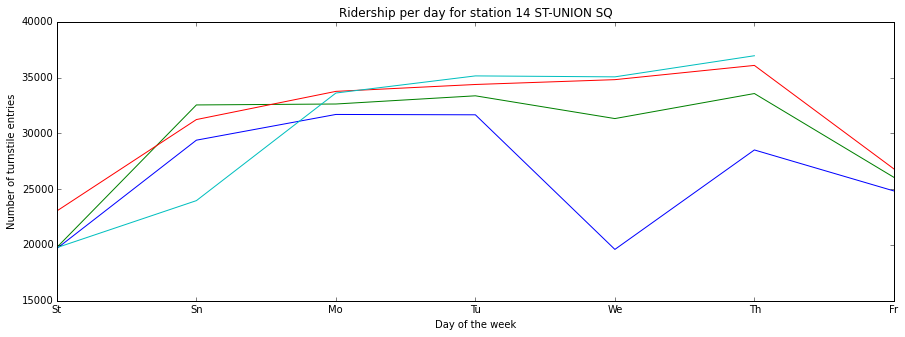

In [233]:
def separate_weeks(time_series):
    time_series_for_each_week = []
    week = []
    for i, (day, count) in enumerate(time_series):
        week.append( (day,count) )
        # every 7 days, start a new week
        # (do this on the last day of the current week)
        if i%7 == 6:
            time_series_for_each_week.append(week)
            week = []
    # at the end of the for loop, if there are some left
    # over, put this partial week as the last (partial) week
    time_series_for_each_week.append(week)
    return time_series_for_each_week


def rainbow_plot_for_station(station_name, station_to_daily_time_series):
    time_series = station_to_daily_time_series[station_name]
    time_series_for_each_week = separate_weeks(time_series)
    plt.figure(figsize=(15,5))
    for week in time_series_for_each_week:
        days, counts = zip(*week)
        days = range(len(counts))
        plt.plot(days,counts)
    plt.xlabel('Day of the week')
    plt.ylabel('Number of turnstile entries')
    plt.xticks(np.arange(7),['St','Sn','Mo','Tu','We','Th','Fr'])
    plt.title('Ridership per day for station %s'%station_name)
    
    
rainbow_plot_for_station('14 ST-UNION SQ', station_to_daily_time_series)


##Challenge 9
- Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [234]:
def total_traffic(time_series):
    return sum([count for day,count in time_series])

def station_time_series_item_to_station_total_traffic(item):
    station, time_series = item
    return total_traffic(time_series), station

traffic_report = map(station_time_series_item_to_station_total_traffic,
                 station_to_daily_time_series.items())

for tot_traffic, station in sorted(traffic_report, reverse=True)[:30]:
    print '%-18s %s' % (station, tot_traffic)
    

42 ST-GRD CNTRL    3191992
42 ST-PA BUS TE    2396771
34 ST-PENN STA     2016352
42 ST-TIMES SQ     1906670
34 ST-HERALD SQ    1670192
86 ST              1453363
47-50 ST-ROCK      1347132
MAIN ST            1197571
ROOSEVELT AVE      1105137
59 ST              1098360
LEXINGTON-53 ST    954511
72 ST              940759
W 4 ST-WASH SQ     907010
JAMAICA CENTER     866463
PATH WTC           862301
42 ST-BRYANT PK    825354
14 ST-UNION SQ     799422
77 ST              794806
BOROUGH HALL/CT    721704
BARCLAYS CENTER    712839
JAY ST-METROTEC    708005
33 ST              674216
68ST-HUNTER COL    639785
BEDFORD AVE        635539
57 ST-7 AVE        629000
BOWLING GREEN      625178
CROWN HTS-UTICA    611196
FOREST HILLS-71    606484
UNION TPK-KEW G    596326
49 ST-7 AVE        581121


##Challenge 10
- Make a single list of these total ridership values and plot it with `plt.hist(total_ridership_counts)` to get an idea about the distribution of total ridership among different stations.   
This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

*Additional Hint*:    
If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a `plt.bar` graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be `0,1,2,3,...`, so you can do 

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

    

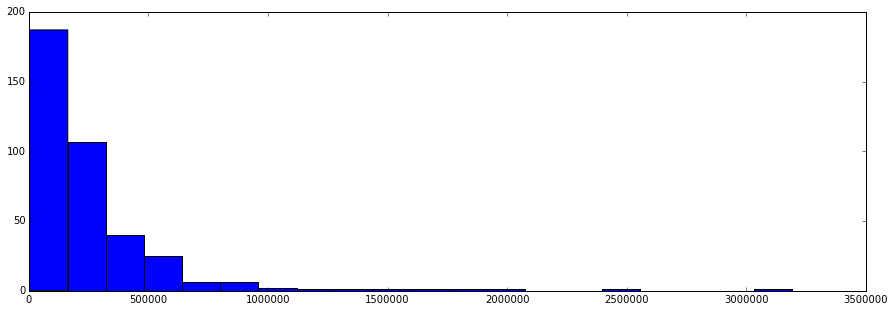

In [236]:
total_ridership_counts = [ridership for ridership, station in traffic_report]
plt.figure(figsize=(15,5))
hist = plt.hist(total_ridership_counts, bins=20)

Well, ok, the majority of the stations fall into the first bins with lower counts.   
We can't see a lot of detail.   
To get a better understanding, let's look at the histogram of log counts.

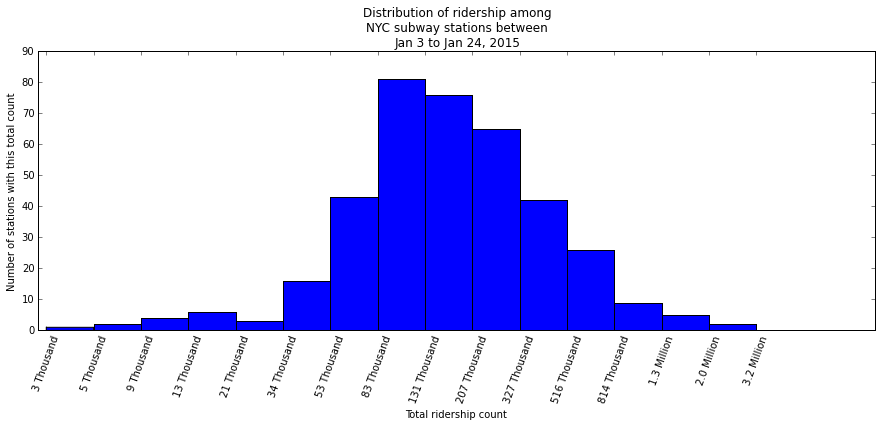

In [241]:
import math
log_counts = [math.log10(count) for count in total_ridership_counts]
plt.figure(figsize=(15,5))
n,bins,patches = hist = plt.hist(log_counts, bins=15)

# Labels for the logarithmic x axis
def log_count_to_label(log_count):
    if log_count <= 6:
        return '%.0f Thousand' % 10**(log_count-3)
    else:
        return '%.1f Million' % 10**(log_count-6)
    
tick_labels = map(log_count_to_label, bins)
ticks = plt.xticks(bins, tick_labels, rotation=70)
plt.xlabel("Total ridership count")
plt.ylabel("Number of stations with this total count")
plt.title("Distribution of ridership among\n"
          "NYC subway stations between\n"
          "Jan 3 to Jan 24, 2015")


If you switch the y axis to logarithmic as well, you can see even more detail, but you lose some readability.   
You can do this by setting

    log=True
    
in the `plt.hist()` call. Below I copy paste the same code with only this difference

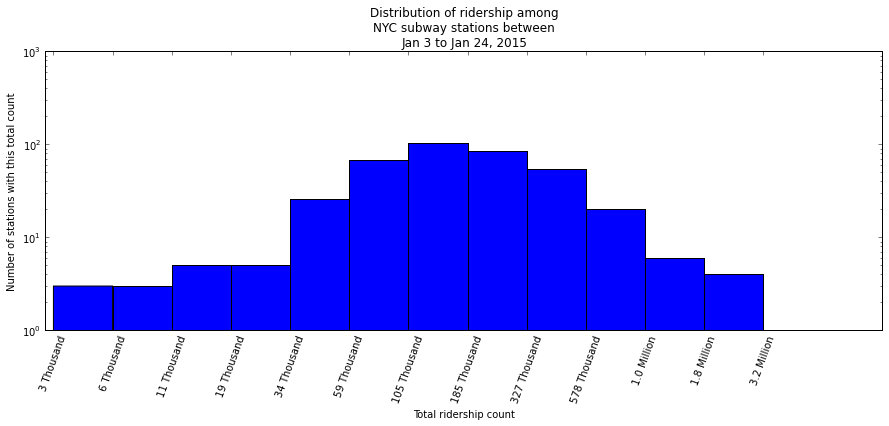

In [242]:
log_counts = [math.log10(count) for count in total_ridership_counts]
plt.figure(figsize=(15,5))
n,bins,patches = hist = plt.hist(log_counts, log=True, bins = 12)
tick_labels = map(log_count_to_label, bins)
ticks = plt.xticks(bins, tick_labels, rotation=70)
plt.xlabel("Total ridership count")
plt.ylabel("Number of stations with this total count")
plt.title("Distribution of ridership among\n"
          "NYC subway stations between\n"
          "Jan 3 to Jan 24, 2015")

This really does not add much. But if one of the peaks dominated and you couldn't see the other peaks, using a log scale for the y axis would have helped.

And finally, the bar graph mentioned in the _Additional Hint_ for the top 30 stations

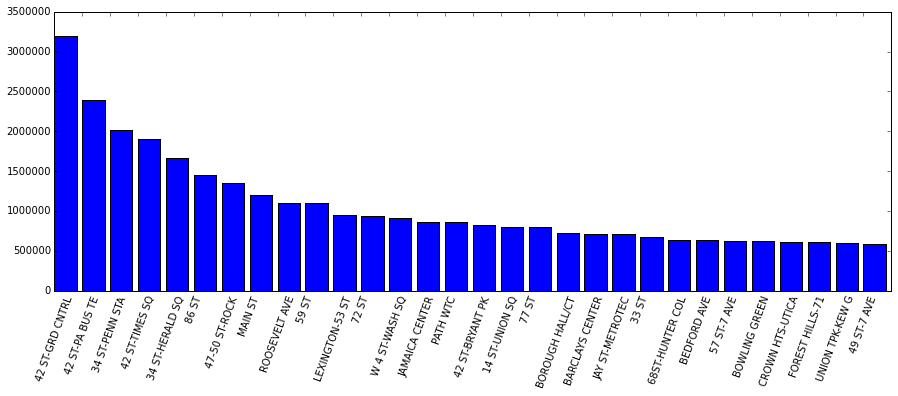

In [246]:
top_stations = sorted(traffic_report, reverse=True)[:30]
counts, stations = zip(*top_stations)
indices = range(len(counts))
plt.figure(figsize=(15,5))
plt.bar(indices, counts)
ticks = plt.xticks(indices, stations, rotation=70)